In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
# transform = transforms.Compose([transforms.ToTensor()])
# traindata = torchvision.datasets.MNIST(root='./data', train=True,download=True,transform=transform)
# trainloader = DataLoader(traindata,batch_size = 64)

train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=False,
                                           transform=transforms.ToTensor(),
                                           download=True)

# fig, label = train_dataset[0]
# print(f'fig shape : {fig.size()}, label : {label}')

# fig, axes = plt.subplots(1, 5)
# for i in range(5):
#     axes[i].imshow(train_dataset[i][0].view(-1, 28), cmap='gray')
#     axes[i].axis("off")
# import matplotlib.pyplot as plt
# fig = plt.figure(figsize=(10,4))

# for i in range(10):
#     ax = fig.add_subplot(2,5,i+1)
#     ax.imshow(data[i,0])

Epoch [1/10], Loss: 0.9527846888692648
Epoch [2/10], Loss: 0.9253688577904122
Epoch [3/10], Loss: 0.9253702044232822
Epoch [4/10], Loss: 0.9253675946548804
Epoch [5/10], Loss: 0.9253680292985587
Epoch [6/10], Loss: 0.9253669007500606
Epoch [7/10], Loss: 0.9253678825110007
Epoch [8/10], Loss: 0.925367651209394
Epoch [9/10], Loss: 0.9253695228460755
Epoch [10/10], Loss: 0.9253670568151007


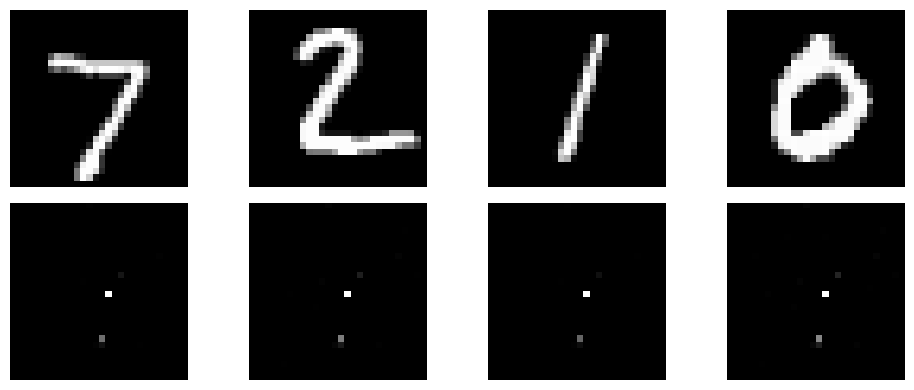

In [3]:
# ハイパーパラメータの設定
num_epochs = 10
batch_size = 128
learning_rate = 0.001
hidden_size = 32

# 乱数シード設定
torch.manual_seed(1205)

# オートエンコーダのモデルを定義
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, hidden_size),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# MNISTデータセット読み込み
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # 正規化
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# オートエンコーダモデルのインスタンスを作成
autoencoder = Autoencoder()

# 損失関数とオプティマイザを定義
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

# モデルのトレーニング
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in train_loader:
        # 入力データを平滑化します
        images = images.view(images.size(0), -1)
        
        # 順伝播と逆伝播
        optimizer.zero_grad()
        outputs = autoencoder(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # エポックごとの損失を表示
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

# テストデータのエンコードとデコード
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

# 最初の4つのテスト画像を取得します
images, _ = next(iter(test_loader))
images = images.view(images.size(0), -1)

# テスト画像をエンコード・デコードします
encoded_images = autoencoder.encoder(images)
decoded_images = autoencoder(images)

# 元の画像とデコードされた画像を可視化します
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 4))

for i in range(4):
    # 元の画像
    axes[0, i].imshow(images[i].view(28, 28).cpu(), cmap='gray')
    axes[0, i].axis('off')
    
    # デコードされた画像
    axes[1, i].imshow(decoded_images[i].view(28, 28).detach().cpu(), cmap='gray')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()